# Loading Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from torchvision.datasets import CIFAR10

In [2]:
def get_dataset(train):
    data = CIFAR10('.', train=train, download=True)
    return data.data, data.targets

In [3]:
(x, y), (test_X, test_y) = get_dataset(True), get_dataset(False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
x.shape

(50000, 32, 32, 3)

In [5]:
train_size = 40000

In [6]:
# get training and testing dataset
features, labels = x[:train_size], y[:train_size]
features_test, labels_test = x[train_size:], y[train_size:]

In [7]:
features = np.array(features)
number_of_training_data = len(features)
features_test = np.array(features_test)
number_of_testing_data = len(features_test)

print("Number of training data:", number_of_training_data)
print("Training data shape:", features.shape)
print("Number of testing data:", number_of_testing_data)
print("Testing data shape:", features_test.shape)

Number of training data: 40000
Training data shape: (40000, 32, 32, 3)
Number of testing data: 10000
Testing data shape: (10000, 32, 32, 3)


# Data preprocessing

In [8]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [10]:
resnet = models.resnet50(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
step = 7

In [12]:
norm_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Feature Extraction

In [13]:
from math import copysign, log10, log1p

In [14]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
  huMoments = cv2.HuMoments(cv2.moments(image)).flatten()
  for i in range(0,7):
    huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))
  return huMoments

In [15]:
def feature_extraction(features):
  data = []

  for index, feature in enumerate(features):
    fv_hu_moments = fd_hu_moments(feature)
    data.append(fv_hu_moments)
  return data

# Classification

In [16]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

In [17]:
def image_processing(features, number_of_data, weight_index):
    features_normalized, features_processed = [], []
    t0 = time.time()

    # apply z score normalization
    for image in features:
        image_norm = norm_transform(image)
        features_normalized.append(image_norm)
    
    # apply cnn
    loader = DataLoader(features_normalized, batch_size=number_of_data // step, shuffle=False)
    for images in loader:
        images = images.to(device)
        images_conv = resnet.conv1(images) # (batch_size, 64, 128, 128)
        images_conv = np.array([conv[weight_index].cpu().detach().numpy() for conv in images_conv])
        # images_conv = images_conv.mean(dim=(1)) # semua feature map di avg (batch_size, 128, 128)
        features_processed.append(images_conv)
    
    t1 = time.time()

    return np.vstack(features_processed)

In [18]:
accuracies = []
for weight_index in range(0, 16): # (0, 16), (16, 32), (32, 48), (48, 64)
  t0 = time.time()
  features_processed = image_processing(features, number_of_training_data, weight_index)
  features_test_processed = image_processing(features_test, number_of_testing_data, weight_index)

  data = feature_extraction(features_processed)
  target = labels

  data_test = feature_extraction(features_test_processed)
  target_test = labels_test

  clf = svm.SVC(gamma=0.001, C=100.)
  clf.fit(data, target)

  y_pred = clf.predict(data_test)
  y_test = target_test

  t1 = time.time()
  print("Finished on index-{}: {:.0f}s".format(weight_index, t1-t0))

  accuracies.append(accuracy_score(y_test,y_pred))

Finished on index-0: 300s
Finished on index-1: 296s
Finished on index-2: 297s
Finished on index-3: 306s
Finished on index-4: 315s
Finished on index-5: 324s
Finished on index-6: 308s
Finished on index-7: 303s
Finished on index-8: 293s
Finished on index-9: 302s
Finished on index-10: 324s
Finished on index-11: 311s
Finished on index-12: 313s
Finished on index-13: 334s
Finished on index-14: 304s
Finished on index-15: 314s


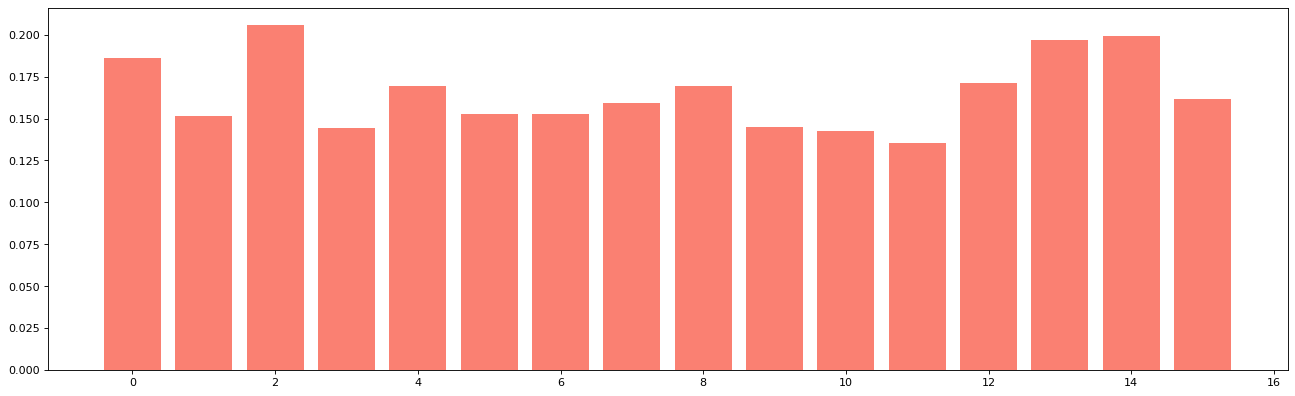

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)

x = range(0, 16)
y = accuracies

plt.bar(x, y, color='salmon')
plt.show()

In [23]:
for (i, j) in zip(x, y):
  print(i, j)

0 0.186
1 0.1513
2 0.2057
3 0.1442
4 0.1696
5 0.1528
6 0.1526
7 0.1595
8 0.1694
9 0.1449
10 0.1426
11 0.1354
12 0.1714
13 0.1969
14 0.1991
15 0.1615
